In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [31]:
combined_df = pd.read_csv("0515_Feature_Extraction.csv")
combined_df.head(100)

,Unnamed: 0.1,Unnamed: 0_x,forum,year,decision,avg_score,INTRODUCTION,CONCLUSION,intro_nominalization_count,intro_passive_voice_count,...,Unnamed: 0,intro_nonfinite_relative_clause_count_y,intro_pp_as_postmodifier_count,intro_attributive_adjective_count,intro_linking_adverbial_count,concl_nonfinite_relative_clause_count_y,concl_pp_as_postmodifier_count,concl_attributive_adjective_count,concl_linking_adverbial_count,decision_binary
0,0,0,B1e-kxSKDH,2020,Accept (Poster),6.000000,Obtaining structured knowledge about the world...,"We introduced STOVE, a structured, object-awar...",67,20,...,0,2,94,142,45,5,228,346,156,1
1,1,1,B1e3OlStPB,2020,Accept (Spotlight),6.666666,Spherical data is found in many applications (...,This work showed that DeepSphere strikes an in...,30,5,...,1,1,30,45,14,3,129,199,91,1
2,2,2,B1e5TA4FPr,2020,Reject,3.000000,Machine learning algorithms play an important ...,0,37,10,...,2,4,41,72,15,0,0,0,0,0
3,3,3,B1e9Y2NYvS,2020,Accept (Spotlight),6.666666,Neural ordinary differential equations (Chen e...,"In this paper, we first empirically study the ...",46,11,...,3,1,64,132,23,0,33,80,49,1
4,4,4,B1eBoJStwr,2020,Reject,3.000000,Semi-supervised learning offers the tantalizin...,We have shown that consistency regularization...,27,4,...,4,4,19,42,13,5,183,328,113,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,96,BJgnXpVYwS,2020,Accept (Talk),8.000000,We study optimization algorithms for neural ne...,0,27,2,...,96,0,29,64,24,0,0,0,0,1
96,96,97,BJgqQ6NYvB,2020,Accept (Poster),7.333334,Semantic segmentation predicts pixel-level ann...,We introduced a novel multi-resolution NAS fra...,29,4,...,97,0,28,85,24,3,104,206,110,1
97,97,98,BJgr4kSFDS,2020,Accept (Poster),6.666666,Knowledge graphs (KGs) capture different types...,In this paper we proposed a reasoning framewor...,24,9,...,98,3,46,79,30,1,75,76,62,1
98,98,99,BJgxzlSFvr,2020,Reject,1.000000,Learning to rank applies supervised or semi-su...,"In this paper, we proposed a new neural networ...",28,12,...,99,2,28,43,24,0,48,68,48,0


In [32]:
combined_df.shape

(3232, 180)

### VIF

In [33]:
def calculate_vif(X, thresh=5.0):
    """
    Recursively removes features with VIF greater than threshold.
    Returns filtered DataFrame and list of removed features.
    """
    removed = []
    while True:
        vif = pd.Series(
            [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
            index=X.columns
        )
        max_vif = vif.max()
        if max_vif > thresh:
            remove_feature = vif.idxmax()
            print(f"Dropping '{remove_feature}' with VIF = {max_vif:.2f}")
            X = X.drop(columns=[remove_feature])
            removed.append(remove_feature)
        else:
            break
    return X, removed


In [ ]:
# select columns with keywords
intro_cols = [col for col in combined_df.columns if "INTRODUCTION" in col]
concl_cols = [col for col in combined_df.columns if "CONCLUSION" in col]

# extract features
X_intro_raw = combined_df[intro_cols].select_dtypes(include='number').fillna(0)
X_concl_raw = combined_df[concl_cols].select_dtypes(include='number').fillna(0)

# compute VIF
X_intro_filtered, removed_intro = calculate_vif(X_intro_raw, thresh=5.0)
X_concl_filtered, removed_concl = calculate_vif(X_concl_raw, thresh=5.0)


In [35]:
X_intro_filtered.head(100)

,INTRODUCTION_past_ratio,INTRODUCTION_perfect_ratio,INTRODUCTION_iobj_count,INTRODUCTION_dep_pair_amod_NOUN,INTRODUCTION_dep_pair_det_NOUN,INTRODUCTION_promo_word_ratio,INTRODUCTION_polarity,INTRODUCTION_sentence_length_characters_max,INTRODUCTION_has_transition_word_mean,INTRODUCTION_num_citations_in_sentence_mean,INTRODUCTION_topic_similarity_to_conclusion_mean,INTRODUCTION_dep_pair_prep_NOUN,INTRODUCTION_dep_pair_appos_PROPN,INTRODUCTION_dep_pair_compound_PROPN,INTRODUCTION_dep_pair_appos_NOUN,INTRODUCTION_dep_pair_pcomp_ADP
0,0.011111,0.066667,0,142.0,137.0,0.009479,0.057574,315.0,0.047059,0.141176,0.251031,0.0,0.0,0.0,0.0,0.0
1,0.078947,0.078947,0,45.0,44.0,0.008772,-0.007292,707.0,0.043478,0.304348,0.289183,30.0,0.0,0.0,0.0,0.0
2,0.000000,0.054795,0,72.0,61.0,0.011445,0.081609,453.0,0.041667,0.750000,0.039050,41.0,0.0,0.0,0.0,0.0
3,0.033898,0.042373,0,132.0,108.0,0.016194,0.101079,336.0,0.196078,0.156863,0.412628,64.0,0.0,0.0,0.0,0.0
4,0.048780,0.048780,0,42.0,33.0,0.019178,0.102445,296.0,0.125000,0.250000,0.351081,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000000,0.054545,0,64.0,39.0,0.015656,0.106175,295.0,0.304348,0.478261,-0.031788,0.0,0.0,0.0,0.0,0.0
96,0.054054,0.054054,0,85.0,0.0,0.027174,0.132605,361.0,0.304348,0.043478,0.382212,0.0,0.0,0.0,0.0,0.0
97,0.000000,0.037037,0,79.0,71.0,0.015267,0.078335,601.0,0.113636,0.090909,0.385481,0.0,0.0,0.0,0.0,0.0
98,0.000000,0.084211,0,43.0,72.0,0.009509,-0.044762,387.0,0.103448,0.344828,0.408341,0.0,0.0,0.0,0.0,0.0


In [36]:
X_concl_filtered.head(100)

,CONCLUSION_past_ratio,CONCLUSION_perfect_ratio,CONCLUSION_iobj_count,CONCLUSION_dep_pair_compound_PROPN,CONCLUSION_dep_pair_amod_NOUN,CONCLUSION_dep_pair_det_NOUN,CONCLUSION_ref_count,CONCLUSION_promo_word_ratio,CONCLUSION_hedge_word_ratio,CONCLUSION_polarity,...,CONCLUSION_dep_pair_npadvmod_VERB,CONCLUSION_dep_pair_appos_NOUN,CONCLUSION_dep_pair_conj_NOUN,CONCLUSION_dep_pair_prep_NOUN,CONCLUSION_dep_pair_appos_PROPN,CONCLUSION_dep_pair_nummod_NUM,CONCLUSION_dep_pair_appos_NUM,CONCLUSION_dep_pair_prep_PROPN,CONCLUSION_dep_pair_advmod_VERB,CONCLUSION_dep_pair_compound_NUM
0,0.057471,0.048276,0,388.0,346.0,336.0,9,0.005871,0.015500,0.057512,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.054545,0.040909,0,390.0,0.0,0.0,24,0.005913,0.010783,0.076189,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0,0.0,0.0,0.0,0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.017544,0.017544,0,203.0,80.0,0.0,0,0.007709,0.008811,0.049694,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.116343,0.027701,0,388.0,0.0,0.0,13,0.004456,0.008650,0.071634,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000000,0.000000,0,0.0,0.0,0.0,0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.117073,0.034146,0,347.0,206.0,0.0,4,0.010927,0.005275,0.095632,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.055556,0.031746,0,214.0,0.0,0.0,0,0.009434,0.015094,0.067381,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.076923,0.012821,0,171.0,0.0,0.0,7,0.010194,0.009174,-0.042338,...,0.0,0.0,0.0,0.0,86.0,0.0,0.0,0.0,0.0,0.0


In [37]:
X_intro_filtered.columns

Index(['INTRODUCTION_past_ratio', 'INTRODUCTION_perfect_ratio',
       'INTRODUCTION_iobj_count', 'INTRODUCTION_dep_pair_amod_NOUN',
       'INTRODUCTION_dep_pair_det_NOUN', 'INTRODUCTION_promo_word_ratio',
       'INTRODUCTION_polarity', 'INTRODUCTION_sentence_length_characters_max',
       'INTRODUCTION_has_transition_word_mean',
       'INTRODUCTION_num_citations_in_sentence_mean',
       'INTRODUCTION_topic_similarity_to_conclusion_mean',
       'INTRODUCTION_dep_pair_prep_NOUN', 'INTRODUCTION_dep_pair_appos_PROPN',
       'INTRODUCTION_dep_pair_compound_PROPN',
       'INTRODUCTION_dep_pair_appos_NOUN', 'INTRODUCTION_dep_pair_pcomp_ADP'],
      dtype='object')

In [38]:
X_intro_filtered.shape

(3232, 16)

In [39]:
X_concl_filtered.columns

Index(['CONCLUSION_past_ratio', 'CONCLUSION_perfect_ratio',
       'CONCLUSION_iobj_count', 'CONCLUSION_dep_pair_compound_PROPN',
       'CONCLUSION_dep_pair_amod_NOUN', 'CONCLUSION_dep_pair_det_NOUN',
       'CONCLUSION_ref_count', 'CONCLUSION_promo_word_ratio',
       'CONCLUSION_hedge_word_ratio', 'CONCLUSION_polarity',
       'CONCLUSION_dale_chall_readability_score', 'CONCLUSION_CT_T',
       'CONCLUSION_sentence_length_characters_max',
       'CONCLUSION_has_transition_word_mean',
       'CONCLUSION_num_citations_in_sentence_mean',
       'CONCLUSION_topic_similarity_to_intro_mean',
       'CONCLUSION_dep_pair_nummod_NOUN', 'CONCLUSION_dep_pair_npadvmod_VERB',
       'CONCLUSION_dep_pair_appos_NOUN', 'CONCLUSION_dep_pair_conj_NOUN',
       'CONCLUSION_dep_pair_prep_NOUN', 'CONCLUSION_dep_pair_appos_PROPN',
       'CONCLUSION_dep_pair_nummod_NUM', 'CONCLUSION_dep_pair_appos_NUM',
       'CONCLUSION_dep_pair_prep_PROPN', 'CONCLUSION_dep_pair_advmod_VERB',
       'CONCLUSION_dep_pai

In [40]:
X_concl_filtered.shape

(3232, 27)

### Lasso + CV

In [41]:
# Define target variable
y = combined_df["decision_binary"]
# Standardize features
scaler_intro = StandardScaler()
X_intro_scaled = scaler_intro.fit_transform(X_intro_filtered)

# Train LassoCV
lasso_intro = LassoCV(cv=5, random_state=42).fit(X_intro_scaled, y)

# Extract non-zero features
coef_intro = pd.Series(lasso_intro.coef_, index=X_intro_filtered.columns)
selected_intro = coef_intro[coef_intro != 0].sort_values(ascending=False)

print("🔍 Lasso-selected INTRODUCTION features:")
selected_intro.head(100)

🔍 Lasso-selected INTRODUCTION features:


INTRODUCTION_dep_pair_appos_PROPN                   0.038830
INTRODUCTION_dep_pair_amod_NOUN                     0.027543
INTRODUCTION_promo_word_ratio                       0.017759
INTRODUCTION_num_citations_in_sentence_mean         0.014700
INTRODUCTION_has_transition_word_mean               0.010666
INTRODUCTION_dep_pair_compound_PROPN                0.010560
INTRODUCTION_sentence_length_characters_max         0.001816
INTRODUCTION_dep_pair_appos_NOUN                    0.000133
INTRODUCTION_dep_pair_pcomp_ADP                    -0.006151
INTRODUCTION_polarity                              -0.008765
INTRODUCTION_dep_pair_prep_NOUN                    -0.022994
INTRODUCTION_topic_similarity_to_conclusion_mean   -0.036681
INTRODUCTION_perfect_ratio                         -0.046221
dtype: float64

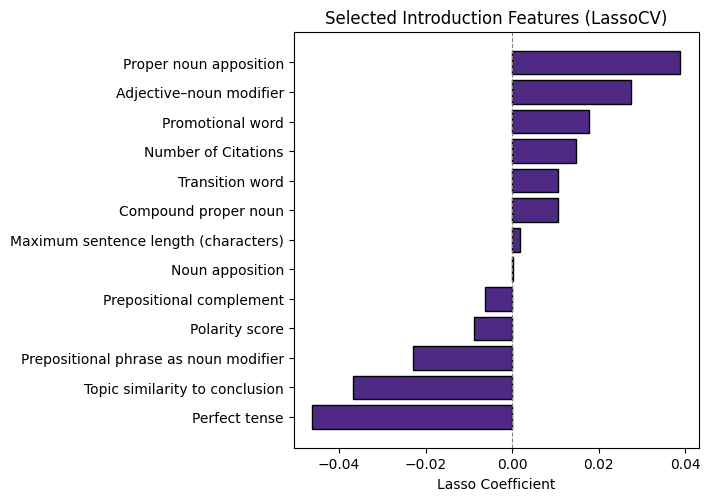

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

# ——  X_intro_filtered  combined_df —— 

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_intro_filtered)
y = combined_df["decision_binary"]

# 2. LassoCV 
lasso = LassoCV(cv=5, random_state=42).fit(X_scaled, y)

coef = pd.Series(lasso.coef_, index=X_intro_filtered.columns)
coef = coef[coef != 0].sort_values(ascending=False)

label_map = {
    "INTRODUCTION_dep_pair_amod_NOUN": "Adjective–noun modifier",
    "INTRODUCTION_dep_pair_det_NOUN": "Determiner–noun construction",
    "INTRODUCTION_dep_pair_compound_PROPN": "Compound proper noun",
    "INTRODUCTION_dep_pair_appos_PROPN": "Proper noun apposition",
    "INTRODUCTION_dep_pair_punct_AUX": "Punctuation–auxiliary relation",
    "INTRODUCTION_dep_pair_pcomp_ADP": "Prepositional complement",
    "INTRODUCTION_topic_similarity_to_conclusion_mean": "Topic similarity to conclusion",
    "INTRODUCTION_dep_pair_attr_AUX": "Auxiliary attribute structure",
    "INTRODUCTION_dep_pair_aux_VERB": "Auxiliary–verb pair",
    "INTRODUCTION_dep_pair_ROOT_PROPN": "Proper noun sentence root",
    "INTRODUCTION_dep_pair_appos_NOUN": "Noun apposition",
    "INTRODUCTION_dep_pair_dep_PUNCT": "Punctuation dependency",
    "INTRODUCTION_dep_pair_punct_VERB": "Punctuation–verb relation",
    "INTRODUCTION_dep_pair_nummod_PROPN": "Numerical modifier of proper noun",
    "INTRODUCTION_perfect_ratio": "Perfect tense",
    "INTRODUCTION_dep_pair_nmod_NOUN": "Noun modifier structure",
    "INTRODUCTION_dep_pair_ROOT_NUM": "Numerical sentence root",
    "INTRODUCTION_promo_word_ratio": "Promotional word",
    "INTRODUCTION_dep_pair_punct_NOUN": "Punctuation–noun",
    "INTRODUCTION_num_citations_in_sentence_mean": "Number of Citations",
    "INTRODUCTION_has_transition_word_mean": "Transition word",
    "INTRODUCTION_dep_pair_compound_NOUN": "Compound noun",
    "INTRODUCTION_in_brackets_max": "Maximum bracket depth",
    "INTRODUCTION_dep_pair_prep_NOUN": "Prepositional phrase as noun modifier",
    "INTRODUCTION_dep_pair_conj_PROPN": "Proper noun conjunction",
    "INTRODUCTION_polarity": "Polarity score",
    "INTRODUCTION_in_brackets_mean": "Average bracket",
    "INTRODUCTION_dep_pair_dobj_VERB": "Verb–direct object pair",
    "INTRODUCTION_dep_pair_nsubj_VERB": "Verb–subject pair",
    "INTRODUCTION_dep_pair_prep_VERB": "Verb–preposition structure",
    "INTRODUCTION_sentence_length_characters_max": "Maximum sentence length (characters)"
}

coef = coef.rename(index=label_map)

# 5.plot_df
plot_df = coef.reset_index()
plot_df.columns = ["Feature", "Coef"]
plot_df = plot_df.set_index("Feature")

n = len(plot_df)
height_per_bar = 0.4
fig_height = max(4, n * height_per_bar)

fig, ax = plt.subplots(figsize=(6, fig_height))

ax.barh(
    plot_df.index,
    plot_df["Coef"],
    color="#4E2A84",
    edgecolor="black"
)

ax.axvline(0, color="grey", linestyle="--", linewidth=0.8)
ax.invert_yaxis()
ax.set_xlabel("Lasso Coefficient")
ax.set_title("Selected Introduction Features (LassoCV)")

plt.tight_layout()
plt.subplots_adjust(left=0.3, top=0.9, bottom=0.1)
plt.savefig("significant_intro_Lasso.pdf")
plt.show()


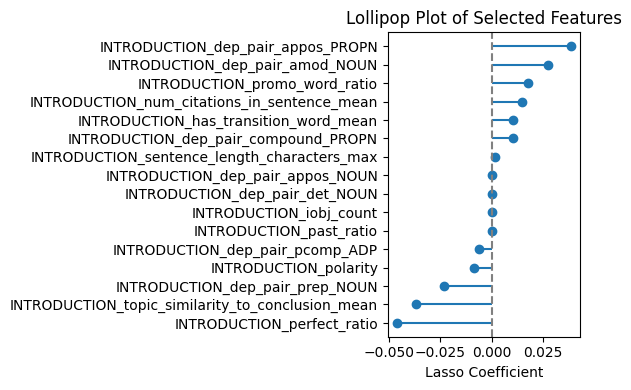

In [46]:
coef = pd.Series(lasso.coef_, index=X_intro_filtered.columns).sort_values()
plt.figure(figsize=(6,4))
plt.hlines(coef.index, 0, coef.values)
plt.plot(coef.values, coef.index, 'o')
plt.axvline(0, color='grey', linestyle='--')
plt.xlabel('Lasso Coefficient')
plt.title('Lollipop Plot of Selected Features')
plt.tight_layout()
plt.show()


In [47]:
scaler_concl = StandardScaler()
X_concl_scaled = scaler_concl.fit_transform(X_concl_filtered)

lasso_concl = LassoCV(cv=5, random_state=42).fit(X_concl_scaled, y)

coef_concl = pd.Series(lasso_concl.coef_, index=X_concl_filtered.columns)
selected_concl = coef_concl[coef_concl != 0].sort_values(ascending=False)

print("🔍 Lasso-selected CONCLUSION features:")
selected_concl.head(100)

🔍 Lasso-selected CONCLUSION features:


CONCLUSION_dale_chall_readability_score      0.191137
CONCLUSION_dep_pair_compound_PROPN           0.127062
CONCLUSION_CT_T                              0.110994
CONCLUSION_ref_count                         0.051522
CONCLUSION_dep_pair_det_NOUN                 0.033037
CONCLUSION_dep_pair_amod_NOUN                0.025594
CONCLUSION_has_transition_word_mean          0.013797
CONCLUSION_dep_pair_compound_NUM             0.011192
CONCLUSION_num_citations_in_sentence_mean    0.011041
CONCLUSION_dep_pair_advmod_VERB              0.007230
CONCLUSION_hedge_word_ratio                  0.003706
CONCLUSION_dep_pair_conj_NOUN               -0.007122
CONCLUSION_topic_similarity_to_intro_mean   -0.007991
CONCLUSION_perfect_ratio                    -0.009726
CONCLUSION_past_ratio                       -0.025462
dtype: float64

### Logistic Regression

In [49]:
# ========== INTRO SECTION ==============
import statsmodels.api as sm
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler


# ==== Intro Section ====
X_intro = combined_df[selected_intro.index.tolist()]
y_binary = combined_df["decision_binary"]

scaler = StandardScaler()
X_intro_scaled = pd.DataFrame(scaler.fit_transform(X_intro), columns=X_intro.columns)
X_intro_scaled = sm.add_constant(X_intro_scaled)
X_intro_scaled = X_intro_scaled.replace([np.inf, -np.inf], np.nan).dropna()
y_intro_aligned = y_binary.loc[X_intro_scaled.index]

logit_intro = sm.Logit(y_intro_aligned, X_intro_scaled)
result_intro = logit_intro.fit(method='lbfgs', maxiter=500)

summary_intro = pd.DataFrame({
    "Coef": result_intro.params,
    "Std. Err.": result_intro.bse,
    "z": result_intro.tvalues,
    "p-value": result_intro.pvalues
})


def sig_marker(p):
    if p < 0.001:
        return '⁎⁎⁎'
    elif p < 0.01:
        return '⁎⁎'
    elif p < 0.05:
        return '⁎'
    else:
        return ''

summary_intro["Sig"] = summary_intro["p-value"].apply(sig_marker)
summary_intro["Coef(SE)"] = summary_intro.apply(
    lambda row: f"{row['Coef']:.2f} ({row['Std. Err.']:.2f}){sig_marker(row['p-value'])}", axis=1
)

summary_intro = summary_intro.drop(index="const")
intro_final = summary_intro[["Coef(SE)"]]



label_map = {
    "INTRODUCTION_dep_pair_amod_NOUN": "Adjective–noun modifier",
    "INTRODUCTION_dep_pair_det_NOUN": "Determiner–noun construction",
    "INTRODUCTION_dep_pair_compound_PROPN": "Compound proper noun",
    "INTRODUCTION_dep_pair_appos_PROPN": "Proper noun apposition",
    "INTRODUCTION_dep_pair_punct_AUX": "Punctuation–auxiliary relation",
    "INTRODUCTION_dep_pair_pcomp_ADP": "Prepositional complement",
    "INTRODUCTION_topic_similarity_to_conclusion_mean": "Topic similarity to conclusion",
    "INTRODUCTION_dep_pair_attr_AUX": "Auxiliary attribute structure",
    "INTRODUCTION_dep_pair_aux_VERB": "Auxiliary–verb pair",
    "INTRODUCTION_dep_pair_ROOT_PROPN": "Proper noun sentence root",
    "INTRODUCTION_dep_pair_appos_NOUN": "Noun apposition",
    "INTRODUCTION_dep_pair_dep_PUNCT": "Punctuation dependency",
    "INTRODUCTION_dep_pair_punct_VERB": "Punctuation–verb relation",
    "INTRODUCTION_dep_pair_nummod_PROPN": "Numerical modifier of proper noun",
    "INTRODUCTION_perfect_ratio": "Perfect tense",
    "INTRODUCTION_dep_pair_nmod_NOUN": "Noun modifier structure",
    "INTRODUCTION_dep_pair_ROOT_NUM": "Numerical sentence root",
    "INTRODUCTION_promo_word_ratio": "Promotional word",
    "INTRODUCTION_dep_pair_punct_NOUN": "Punctuation–noun",
    "INTRODUCTION_num_citations_in_sentence_mean": "Number of Citiations",
    "INTRODUCTION_has_transition_word_mean": "Transition word",
    "INTRODUCTION_dep_pair_compound_NOUN": "Compound noun",
    "INTRODUCTION_in_brackets_max": "Maximum bracket depth",
    "INTRODUCTION_dep_pair_prep_NOUN": "Prepositional phrase as noun modifier",
    "INTRODUCTION_dep_pair_conj_PROPN": "Proper noun conjunction",
    "INTRODUCTION_polarity": "Polarity score",
    "INTRODUCTION_in_brackets_mean": "Average bracket",
    "INTRODUCTION_dep_pair_dobj_VERB": "Verb–direct object pair",
    "INTRODUCTION_dep_pair_nsubj_VERB": "Verb–subject pair",
    "INTRODUCTION_dep_pair_prep_VERB": "Verb–preposition structure",
    "INTRODUCTION_sentence_length_characters_max": "Maximum sentence length (characters)"
}

intro_final = intro_final.rename(index=label_map)

intro_final.head(100)

,Coef(SE)
Proper noun apposition,0.25 (0.05)⁎⁎⁎
Adjective–noun modifier,0.15 (0.07)⁎
Promotional word,0.10 (0.04)⁎
Number of Citiations,0.06 (0.04)
Transition word,0.06 (0.04)
Compound proper noun,0.10 (0.09)
Maximum sentence length (characters),1.49 (0.40)⁎⁎⁎
Noun apposition,0.22 (12.81)
Prepositional complement,-0.28 (34.81)
Polarity score,-0.08 (0.04)


In [ ]:
intro_final.to_csv("formatted_intro_superscript_star.csv")


In [50]:
# --- For INTRODUCTION selected features ---

# Select the features and target
X_intro_raw = combined_df[selected_intro.index.tolist()]
y_intro = combined_df["decision_binary"].astype(int)

# Standardize using pandas + retain column names
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_intro_raw), columns=X_intro_raw.columns)

# Add intercept
X_scaled = sm.add_constant(X_scaled)

# Fit logistic regression
logit_intro = sm.Logit(y_intro, X_scaled)
result_intro = logit_intro.fit(method='lbfgs', maxiter=500)

# Print summary
print(result_intro.summary())

                           Logit Regression Results                           
Dep. Variable:        decision_binary   No. Observations:                 3232
Model:                          Logit   Df Residuals:                     3218
Method:                           MLE   Df Model:                           13
Date:                Sun, 18 May 2025   Pseudo R-squ.:                 0.04485
Time:                        11:57:42   Log-Likelihood:                -1998.0
converged:                       True   LL-Null:                       -2091.8
Covariance Type:            nonrobust   LLR p-value:                 4.635e-33
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                                0.7085      0.654      1.084      0.279      -0.573       1.990
INTRODUCTION_dep_

In [51]:
#======= CONCLUSION ==========

# ==== Conclusion Section ====
X_concl = combined_df[selected_concl.index.tolist()]
X_concl_scaled = pd.DataFrame(scaler.fit_transform(X_concl), columns=X_concl.columns)
X_concl_scaled = sm.add_constant(X_concl_scaled)
X_concl_scaled = X_concl_scaled.replace([np.inf, -np.inf], np.nan).dropna()
y_concl_aligned = y_binary.loc[X_concl_scaled.index]

logit_concl = sm.Logit(y_concl_aligned, X_concl_scaled)
result_concl = logit_concl.fit(method='lbfgs', maxiter=500)

summary_concl = pd.DataFrame({
    "Coef": result_concl.params,
    "Std. Err.": result_concl.bse,
    "z": result_concl.tvalues,
    "p-value": result_concl.pvalues
})

summary_concl["Sig"] = summary_concl["p-value"].apply(sig_marker)
summary_concl["Coef(SE)"] = summary_concl.apply(
    lambda row: f"{row['Coef']:.2f} ({row['Std. Err.']:.2f}){sig_marker(row['p-value'])}", axis=1
)

summary_concl = summary_concl.drop(index="const")
concl_final = summary_concl[["Coef(SE)"]]





#concl_final = concl_final.rename(index=label_map_conclusion)

# Display result tables
concl_final.head(100)

,Coef(SE)
CONCLUSION_dale_chall_readability_score,1.24 (0.09)⁎⁎⁎
CONCLUSION_dep_pair_compound_PROPN,0.93 (0.08)⁎⁎⁎
CONCLUSION_CT_T,0.66 (0.08)⁎⁎⁎
CONCLUSION_ref_count,0.37 (0.08)⁎⁎⁎
CONCLUSION_dep_pair_det_NOUN,0.30 (0.06)⁎⁎⁎
CONCLUSION_dep_pair_amod_NOUN,0.18 (0.06)⁎⁎
CONCLUSION_has_transition_word_mean,0.09 (0.05)
CONCLUSION_dep_pair_compound_NUM,0.75 (19.25)
CONCLUSION_num_citations_in_sentence_mean,0.06 (0.06)
CONCLUSION_dep_pair_advmod_VERB,0.71 (16.52)


In [217]:
# === Optional: Save or display ===
concl_final.to_csv("formatted_concl_logit.csv")

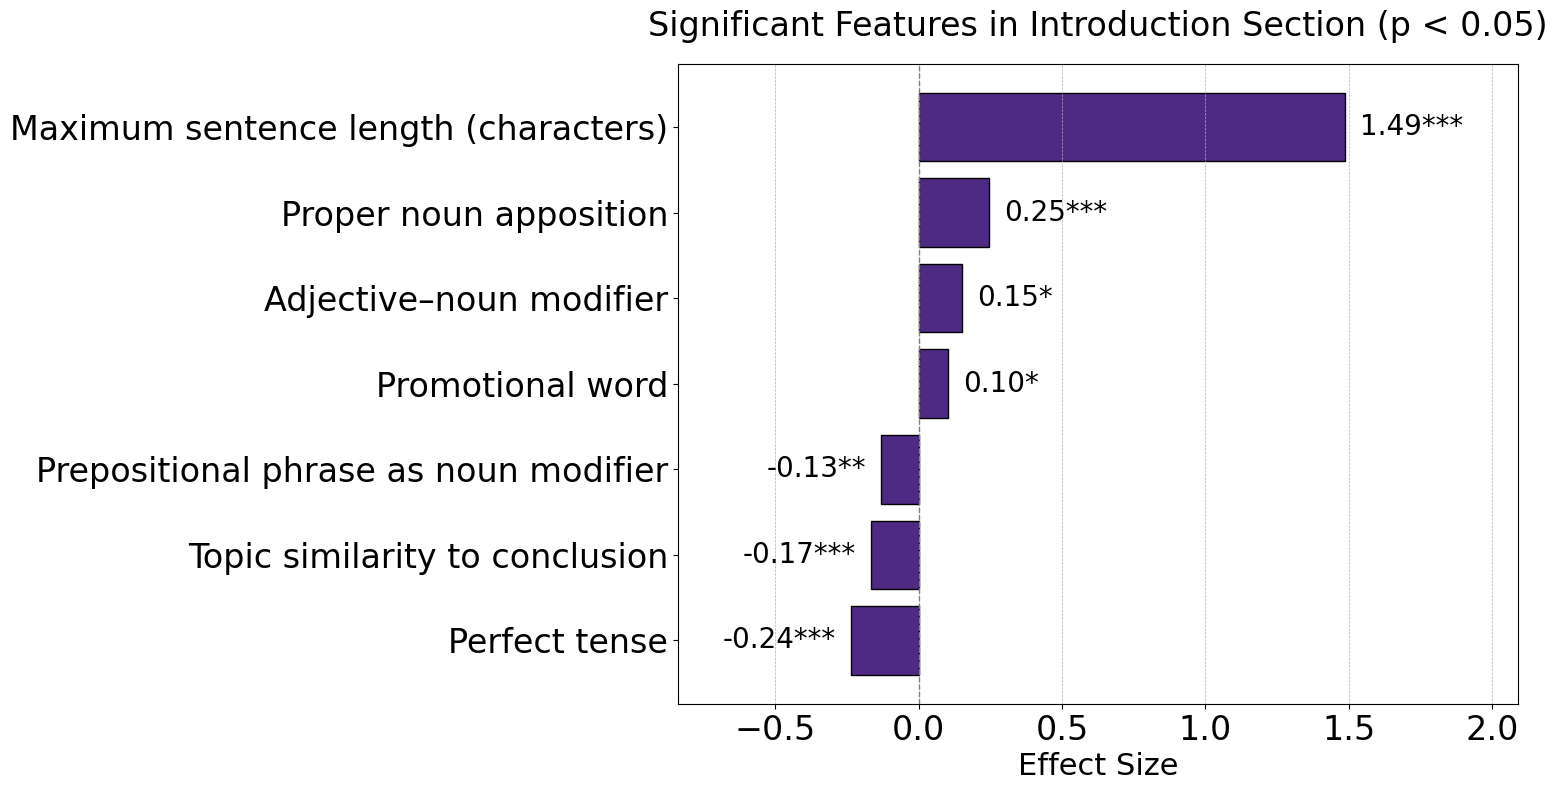

In [67]:
# Step 1: Get full summary
summary_df = pd.DataFrame({
    "Coef": result_intro.params,
    "Std. Err.": result_intro.bse,
    "z": result_intro.tvalues,
    "p-value": result_intro.pvalues
})

# Step 2: Add significance marker
def star_marker(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

summary_df["Significance"] = summary_df["p-value"].apply(star_marker)

# Step 3: Filter only significant features (exclude intercept)
significant_df = summary_df[(summary_df["p-value"] < 0.05) & (summary_df.index != "const")]

# Step 4: Map feature names to human-readable labels
significant_df = significant_df.rename(index=label_map)

# Step 5: Sort by coefficient for plotting
plot_df = significant_df.sort_values(by="Coef", ascending=False)

# ✅ Step 6: Setup figure and plot
plt.figure(figsize=(14, 8))
bars = plt.barh(plot_df.index, plot_df["Coef"], color="#4E2A84", edgecolor='black')
plt.axvline(0, color='gray', linestyle='--', linewidth=1)

# Step 7: Add coefficient + star text labels
labels = [f"{coef:.2f}{star}" for coef, star in zip(plot_df["Coef"], plot_df["Significance"])]
offset = 0.03 * (plot_df["Coef"].max() - plot_df["Coef"].min())
for i, (coef, label) in enumerate(zip(plot_df["Coef"], labels)):
    x_pos = coef + offset if coef > 0 else coef - offset
    ha = 'left' if coef > 0 else 'right'
    plt.text(x_pos, i, label, ha=ha, va='center', fontsize=20, color='black')

# Step 8: Adjust xlim to make room for labels
coef_min = plot_df["Coef"].min()
coef_max = plot_df["Coef"].max()
padding = 0.35 * (coef_max - coef_min)
plt.xlim(coef_min - padding, coef_max + padding)

# Step 9: Final formatting
plt.xlabel("Effect Size", fontsize=22)
plt.title("Significant Features in Introduction Section (p < 0.05)", fontsize=24, pad=20)
plt.yticks(fontsize=24)
plt.xticks(fontsize=24)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.subplots_adjust(left=0.35, right=0.95, top=0.90, bottom=0.1)

# Save and show
plt.savefig("significant_intro_effect_sizes.pdf")
plt.show()


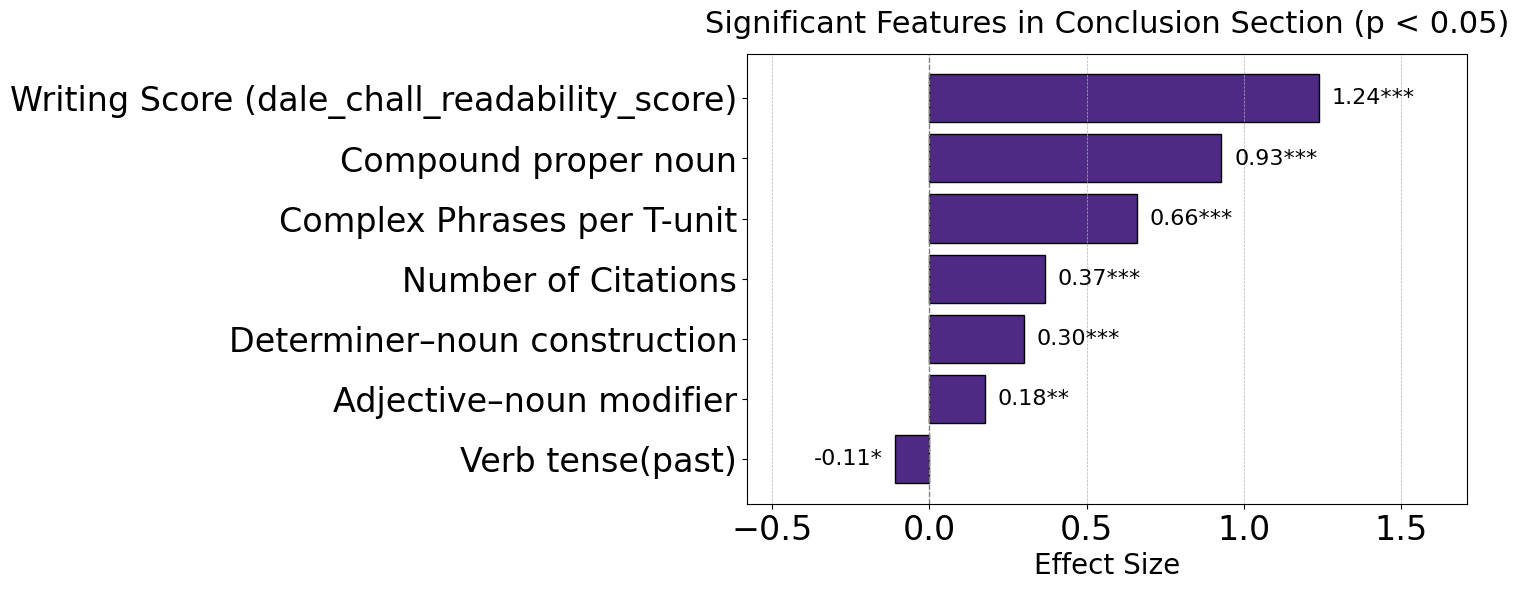

In [71]:
# Step 1: Get full summary
summary_df = pd.DataFrame({
    "Coef": result_concl.params,
    "Std. Err.": result_concl.bse,
    "z": result_concl.tvalues,
    "p-value": result_concl.pvalues
})

# Step 2: Add significance marker
def star_marker(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

summary_df["Significance"] = summary_df["p-value"].apply(star_marker)

# Step 3: Filter only significant features (exclude intercept)
significant_df = summary_df[(summary_df["p-value"] < 0.05) & (summary_df.index != "const")]

# Step 4: Human-readable label mapping
label_map_conclusion = {
    "CONCLUSION_dale_chall_readability_score": "Writing Score (dale_chall_readability_score)",
    "CONCLUSION_dep_pair_compound_PROPN": "Compound proper noun",
    "CONCLUSION_CT_T": "Complex Phrases per T-unit",
    "CONCLUSION_ref_count": "Number of Citations",
    "CONCLUSION_dep_pair_det_NOUN": "Determiner–noun construction",
    "CONCLUSION_dep_pair_amod_NOUN": "Adjective–noun modifier",
    "CONCLUSION_past_ratio": "Verb tense(past)"
}
significant_df = significant_df.rename(index=label_map_conclusion)

# Step 5: Sort by coefficient (descending)
plot_df = significant_df.sort_values(by="Coef", ascending=False)

# Step 6: Plot
plt.figure(figsize=(12, 6))
bars = plt.barh(plot_df.index, plot_df["Coef"], color="#4E2A84", edgecolor="black")
plt.axvline(0, color='gray', linestyle='--', linewidth=1)

# Step 7: Add coefficient + star labels (with enlarged font & spacing)
labels = [f"{coef:.2f}{star}" for coef, star in zip(plot_df["Coef"], plot_df["Significance"])]
offset = 0.03 * (plot_df["Coef"].max() - plot_df["Coef"].min())
for i, (coef, label) in enumerate(zip(plot_df["Coef"], labels)):
    x_pos = coef + offset if coef > 0 else coef - offset
    ha = 'left' if coef > 0 else 'right'
    plt.text(x_pos, i, label, ha=ha, va='center', fontsize=16, color='black')

# Step 8: Adjust xlim
coef_min = plot_df["Coef"].min()
coef_max = plot_df["Coef"].max()
padding = 0.35 * (coef_max - coef_min)
plt.xlim(coef_min - padding, coef_max + padding)

# Step 9: Final formatting
plt.xlabel("Effect Size", fontsize=20)
plt.title("Significant Features in Conclusion Section (p < 0.05)", fontsize=22, pad=15)
plt.yticks(fontsize=24)
plt.xticks(fontsize=24)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.subplots_adjust(left=0.35, right=0.95, top=0.90, bottom=0.15)

# Step 10: Export
plt.savefig("significant_concl_effect_sizes.pdf")
plt.show()
